# Environment Import

In [4]:
import time

import matplotlib.pyplot as plt
import pandas as pd
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.recommendation import ALS
from pyspark.ml.regression import RandomForestRegressor
from pyspark.sql import Row
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, collect_list, split, explode
from pyspark.sql.functions import udf

# Part 1: Init Spark Session with Ratings

In [5]:
def init_spark_session_with_ratings(filename):
    """
    Reads the ratings file and returns the SparkSession and DataFrame created from the file.

    Args:
    filename (str): The path to the ratings file.

    Returns:
    SparkSession, DataFrame: The Spark session and the DataFrame created from the ratings file.
    """

    # Initialize Spark session
    spark = SparkSession.builder \
        .appName("MovieRecommend") \
        .config("spark.executor.memory", "8g") \
        .config("spark.executor.cores", "4") \
        .config("spark.executor.instances", "4") \
        .config("spark.driver.memory", "8G") \
        .getOrCreate()

    # Retrieve SparkContext from SparkSession
    sc = spark.sparkContext
    # sc.setLogLevel("INFO")

    # Load the data into an RDD
    ratings_rdd = sc.textFile(filename)

    # Remove the header from the RDD and parse each line into a tuple
    header = ratings_rdd.first()
    ratings_rdd = (ratings_rdd.filter(lambda line: line != header)
                   .map(lambda line: line.split(','))
                   .map(lambda tokens: (int(tokens[0]), int(tokens[1]), float(tokens[2]), tokens[3])))

    num_ratings = ratings_rdd.count()
    print(f"Number of ratings: {num_ratings}")

    # Convert RDD to DataFrame for easier processing
    ratings_df = spark.createDataFrame(ratings_rdd, ["userId", "movieId", "rating", "timestamp"])

    return spark, ratings_df


spark, ratings_df = init_spark_session_with_ratings("dataset/ratings.csv")
print(ratings_df)

Number of ratings: 25000095
DataFrame[userId: bigint, movieId: bigint, rating: double, timestamp: string]


# Part 2: Basic Recommend with Visualization

+-------+-----------+
|movieId|avg(rating)|
+-------+-----------+
| 133307|        5.0|
| 205419|        5.0|
| 169816|        5.0|
| 165787|        5.0|
| 160028|        5.0|
+-------+-----------+



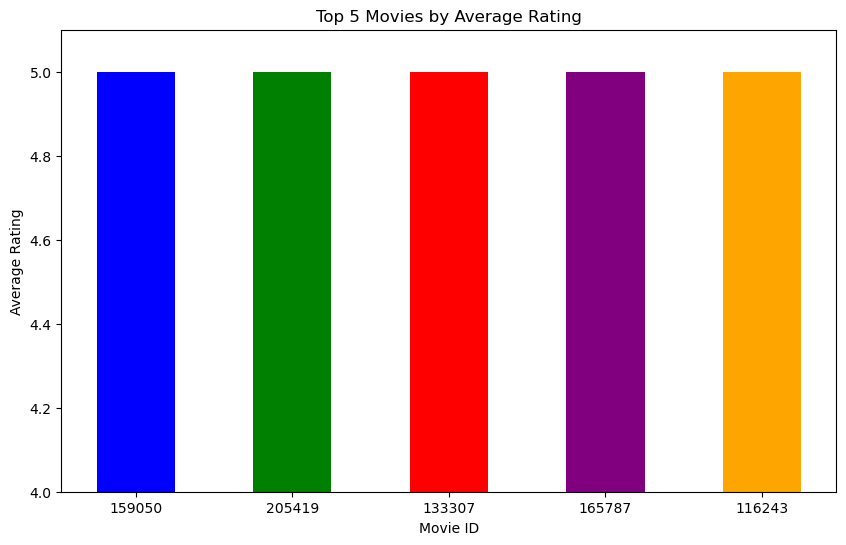

In [6]:
def basic_recommend(spark, ratings_df):
    """
    Performs basic movie recommendation based on the average rating.

    Args:
    ratings_df (DataFrame): The DataFrame containing movie ratings.
    """

    # Compute the average rating for each movie
    avg_ratings_df = ratings_df.groupBy("movieId").avg("rating")

    # Retrieve top 5 movies based on average ratings
    top_movies = avg_ratings_df.orderBy("avg(rating)", ascending=False).limit(5)
    top_movies.show()

    # Plotting the top 5 movies and save the figure to a file
    top_movies_pd = top_movies.toPandas()   # Convert Spark DataFrame to Pandas DataFrame for plotting
    plt.figure(figsize=(10, 6))
    # Adding width to the bars and making them visually distinct
    plt.bar(top_movies_pd['movieId'].astype(str), top_movies_pd['avg(rating)'], width=0.5, color=['blue', 'green', 'red', 'purple', 'orange'])
    plt.xlabel('Movie ID')
    plt.ylabel('Average Rating')
    plt.title('Top 5 Movies by Average Rating')
    plt.ylim(4, 5.1)  # Ensuring that the top of the bars are within the visible range of the plot
    plt.show()
    plt.close()  # Close the plt object to free memory

basic_recommend(spark, ratings_df)

# Part3: ALS Recommend with Visualization

In [9]:
def als_recommend(spark, ratings_df):
    """
    Performs movie recommendations using the ALS (Alternating Least Squares).

    Args:
    spark (SparkSession): SparkSession object for DataFrame operations.
    ratings_df (DataFrame): The DataFrame containing movie ratings.
    """

    # Split the dataset into training and test sets
    (training, test) = ratings_df.randomSplit([0.7, 0.3])

    # Create an ALS model
    als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop", nonnegative=True)

    # Define a grid of parameters for tuning
    param_grid = {
        "rank": [10, 20],
        "maxIter": [5, 10],
        "regParam": [0.01, 0.1]
    }

    # Define multiple evaluators
    rmse_evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
    mae_evaluator = RegressionEvaluator(metricName="mae", labelCol="rating", predictionCol="prediction")

    # Variables to keep track of the best model and its performance
    best_rmse = float('inf')
    best_model = None
    best_error = float('inf')
    best_params = None
    results = []

    # Grid search through the parameter space
    for rank in param_grid["rank"]:
        for max_iter in param_grid["maxIter"]:
            for reg_param in param_grid["regParam"]:
                start_time = time.time()

                # Set model parameters
                als.setParams(rank=rank, maxIter=max_iter, regParam=reg_param)
                
                # Fit ALS model on training data
                model = als.fit(training)
                
                # Evaluate the model on test data
                predictions = model.transform(test)
                rmse = rmse_evaluator.evaluate(predictions)
                mae = mae_evaluator.evaluate(predictions)
                training_time = time.time() - start_time

                # Append results
                results.append({
                    "rank": rank, "maxIter": max_iter, "regParam": reg_param,
                    "RMSE": rmse, "MAE": mae, "Training Time": training_time
                })

                # Update best model
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_model = model
                    best_params = (rank, max_iter, reg_param)

    # Save the results DataFrame to a CSV file
    results_df = pd.DataFrame(results)
    print(results_df)

    # Display the best model parameters and its RMSE
    print("Best Parameters:", best_params)
    print("Best RMSE:", best_error)

    # Generate top 5 movie recommendations for each user using the best model
    recommendations = best_model.recommendForAllUsers(5)
    recommendations.show(truncate=False)

    # Explode the recommendations to create a row for each movie
    recs_exploded = recommendations.withColumn("rec_exp", explode("recommendations")).select("userId", col("rec_exp.movieId"), col("rec_exp.rating"))

    # Plotting the number of times each movie is recommended
    recs_pd = recs_exploded.toPandas()
    plt.figure(figsize=(10, 6))
    recs_pd['movieId'].value_counts().head(5).plot(kind='bar')
    plt.xlabel('Movie ID')
    plt.ylabel('Number of Recommendations')
    plt.title('Top 5 Recommended Movies')
    plt.show()
    plt.close()


als_recommend(spark, ratings_df)

# Part 3: RF Recommend with Visualization

In [3]:
def rf_recommend(spark, ratings_df):
    """
    Perform movie recommendations using a Random Forest model. The method involves processing movie genres and tags,
    applying one-hot encoding, and using these features in a random forest regression model.

    Args:
    spark (SparkSession): SparkSession object for DataFrame operations.
    ratings_df (DataFrame): DataFrame containing movie ratings.
    """

    # Converts a list of vectors into a single vector by summing up each dimension.
    def sum_vectors(vectors):
        return Vectors.dense(sum(v[0] for v in vectors))
    
    sum_vectors_udf = udf(sum_vectors, VectorUDT())

    # Load and preprocess datasets
    movies_df = spark.read.csv("dataset/movies.csv", header=True, inferSchema=True)    # movieId, title, genres
    tags_df = spark.read.csv("dataset/tags.csv", header=True, inferSchema=True)    # userId, movieId, tag, timestamp
    # genome_scores_df = spark.read.csv("dataset/genome-scores.csv", header=True, inferSchema=True)   # movieId, tagId, relevance
    # genome_tags_df = spark.read.csv("dataset/genome-tags.csv", header=True, inferSchema=True)   # tagId, tag

    # Process genres: split, explode, and one-hot encode
    movies_df = movies_df.withColumn("split_genres", split(col("genres"), "\|"))    # Split genres into individual genres
    movies_exploded = movies_df.withColumn("genre", explode(col("split_genres")))   # Explode genres into new rows
    genre_indexer = StringIndexer(inputCol="genre", outputCol="genreIndex")
    indexed_genre = genre_indexer.fit(movies_exploded).transform(movies_exploded)
    genre_encoder = OneHotEncoder(inputCol="genreIndex", outputCol="genreVec")
    encoded_genre = genre_encoder.fit(indexed_genre).transform(indexed_genre)

    # Aggregate the encoded genres back to movie level
    genre_aggregated = encoded_genre.groupBy("movieId").agg(collect_list("genreVec").alias("genreVecList"))
    genre_aggregated = genre_aggregated.withColumn("genresVec", sum_vectors_udf("genreVecList"))

    # Process tags using StringIndexer + OneHotEncoder
    tag_indexer = StringIndexer(inputCol="tag", outputCol="tagIndex")
    tag_model = tag_indexer.fit(tags_df)
    indexed_tags = tag_model.transform(tags_df)
    tag_encoder = OneHotEncoder(inputCols=["tagIndex"], outputCols=["tagVec"])
    tags_encoded = tag_encoder.fit(indexed_tags).transform(indexed_tags)

    # Explode tag vectors into a list of features for each movie
    movie_tags_features = tags_encoded.groupBy('movieId').agg(F.collect_list('tagVec').alias('tagVectors'))
    movie_tags_features = movie_tags_features.withColumn('tagFeatures', sum_vectors_udf('tagVectors')).drop('tagVectors')

    # Combine movie features with ratings
    complete_data_df = ratings_df.join(genre_aggregated.select("movieId", "genresVec"), "movieId").join(movie_tags_features, "movieId")

    # Create feature vectors
    assembler = VectorAssembler(inputCols=["genresVec", "tagFeatures"], outputCol="features")
    data_ready = assembler.transform(complete_data_df)

    # Splitting the dataset
    training_features, test_features = data_ready.randomSplit([0.7, 0.3])

    # Training the Random Forest model
    rf = RandomForestRegressor(featuresCol="features", labelCol="rating")
    model = rf.fit(training_features)

    # Evaluate model on test dataset
    predictions_df = model.transform(test_features)
    rmse_evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
    mae_evaluator = RegressionEvaluator(metricName="mae", labelCol="rating", predictionCol="prediction")

    # Calculate and output evaluation metrics
    rmse = rmse_evaluator.evaluate(predictions_df)
    mae = mae_evaluator.evaluate(predictions_df)
    print(f"Root Mean Square Error (RMSE): {rmse}")
    print(f"Mean Absolute Error (MAE): {mae}")

    # Get top5 movie recommendations
    top_predictions = predictions_df.orderBy('prediction', ascending=False).limit(5)

    # Join with the movies dataframe to get movie titles
    top_movies_with_titles = top_predictions.join(movies_df, 'movieId').select('title', 'prediction')

    # Convert to pandas dataframe for visualization
    top_movies_pd = top_movies_with_titles.toPandas()
    top_movies_pd.set_index('title', inplace=True)

    # Plot
    plt.figure(figsize=(12, 8))
    top_movies_pd['prediction'].plot(kind='bar')
    plt.xlabel('Predicted Rating')
    plt.ylabel('Movie Title')
    plt.title('Top 5 Movie Recommendations')
    plt.tight_layout()
    plt.show()
    plt.close()


rf_recommend(spark, ratings_df)

23/11/23 08:54:35 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 6 (TID 52): Attempting to kill Python Worker


# Part 4: Model Comparison

**ALS model**:
+ Advantages: It is suitable for large-scale data sets, can effectively handle sparsity problems, and is often used in recommendation systems.
+ Disadvantages: Need to adjust multiple parameters, sensitive to cold start issues.

**Random forest model**:
+ Advantages: It handles nonlinear relationships well and is less prone to overfitting.
+ Disadvantages: A large amount of feature engineering is required and the computational cost is high.